In [36]:
pip install nltk


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# importing libraries
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [38]:
# Setting device to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
     device = torch.device("cpu")

print(device)

cuda


In [39]:
# loading dataset
Dataset = 'IMDB_Dataset.csv'
dataset = pd.read_csv(Dataset)
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [40]:
# assigining x and y values and splitting the dataset into train and test datasets
X= dataset['review'].values
y = dataset['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size = 0.33)

In [41]:
# encoding sentiment values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# removing unwanted text using regualr expressions
def preprocessing_data(review):
    review=re.sub("\W+",' ',review)
    review=re.sub(r'\sn\s',' ',review)
    review=re.sub(r'\sr',' ',review)
    review=re.sub(r'[0-9]',' ',review)
    review=re.sub(r'\sxac',' ',review)
    review=re.sub(r'\sxe',' ',review)
    review=re.sub(r'\sx\s',' ',review)
    review=re.sub(r'\sdx\s',' ',review)
    review=re.sub(r'\sck\s',' ',review)
    review=re.sub(r'\sxc\s',' ',review)
    review=re.sub(r'\sxbd\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxt\s',' ',review)
    review=re.sub(r'\sxf\s',' ',review)
    review=re.sub(r'\sxp\s',' ',review)
    review=re.sub(r'\sxzy\s',' ',review)
    review=re.sub(r'\sxs\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxsr\s',' ',review)
    review=re.sub(r'\sda\s',' ',review)
    review=re.sub(r'\sc\s',' ',review)
    review=re.sub(r'b\s+',' ',review)
    review=re.sub(r'\s+',' ',review)
    review=re.sub(r'\s[a-z]\s',' ',review)

    return review




In [45]:
# tokenization of the text 
def tokenize(x_train,x_test):
    word_list = []
    train_list = []
    test_list = []

    stop_words = set(stopwords.words('english')) 
    for i in x_train:
        for word in i.lower().split():
            word = preprocessing_data(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    text = Counter(word_list)
    total_words=len(text)
    sorted_words=text.most_common(1500)
    vocab = {w:i+1 for i,(w,u) in enumerate(sorted_words)}
    
    
    for i in x_train:
            train_list.append([vocab[preprocessing_data(word)] for word in i.lower().split() 
                                     if preprocessing_data(word) in vocab.keys()])
    for j in x_test:
            test_list.append([vocab[preprocessing_data(word)] for word in j.lower().split() 
                                    if preprocessing_data(word) in vocab.keys()])
            
    return np.array(train_list), np.array(test_list),vocab

In [46]:
x_train,x_test,vocabulary = tokenize(x_train,x_test)

<ipython-input-45-c5b0e07da60e>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_list), np.array(test_list),vocab


In [47]:
# padding to a sequence of length 300 
def padding_col(reviews, len_seq):
    features = np.zeros((len(reviews), len_seq),dtype=int)
    for i, review in enumerate(reviews):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:len_seq]
    return features

In [48]:
# padding x values of training and testing data
x_train_ = padding_col(x_train,300)
x_test_= padding_col(x_test,300)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_ = np.array(y_train_encoded, dtype=np.float64)
y_test_ = np.array(y_test_encoded, dtype=np.float64)

In [49]:
#Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_), torch.from_numpy(y_train_))
test_data = TensorDataset(torch.from_numpy(x_test_), torch.from_numpy(y_test_))

# dataloaders
batch_size = 50
# Initializing train loader and test loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [50]:
#defining LSTM Architecture 
class RNN(nn.Module):
    
  def __init__(self,input_size, dim_embedding, dim_hidden, num_layers,prob_drop = 0.5):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.dim_emdbedding = dim_embedding
    self.dim_hidden = dim_hidden
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size = dim_embedding, num_layers = num_layers, hidden_size = dim_hidden, batch_first = True)
    self.embedding = nn.Embedding(input_size,dim_embedding)
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(self.dim_hidden, dim_output)
    self.sig = nn.Sigmoid()
  def forward(self, x, hidden):
    batch_size = x.size(0)
    embedd = self.embedding(x)
    out_lstm, hidden = self.lstm(embedd,hidden)
    output_lstm = out_lstm.contiguous().view(-1,self.dim_hidden)
    out = self.dropout(output_lstm)
    out = self.fc(out)
    sig_output = self.sig(out)
    sig_output = sig_output.view(batch_size, -1)
    sig_output = sig_output[:,-1]
    return sig_output, hidden
  
  def init_hidden(self, batch_size):
    h0 = torch.zeros((self.num_layers,batch_size,self.dim_hidden)).to(device)
    c0 = torch.zeros((self.num_layers,batch_size,self.dim_hidden)).to(device)
    hidden = (h0,c0)
    return hidden

In [51]:
# inputs to the LSTM model
input_size = len(vocabulary) + 1
num_layers = 3
dim_hidden = 256
dim_embedding = 64
dim_output = 1
model = RNN(input_size, dim_embedding, dim_hidden, num_layers,prob_drop = 0.5)
model.to(device)
print(model)

RNN(
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True)
  (embedding): Embedding(1501, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [72]:
# initializing loss 
criterion = nn.BCELoss()
# initilizing optimization functions
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [73]:
# Training LSTM  with 10 epochs
clip = 5
num_epochs = 10
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):
    training_losses = []
    training_accuracy = 0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        h = tuple([i.data for i in h])
        model.zero_grad()
        output, h = model(inputs,h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_losses.append(loss.item())
        output = torch.round(output.squeeze())
        accuracy = torch.sum(output == labels.squeeze()).item()
        training_accuracy += accuracy
        nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
    train_loss_ = np.mean(training_losses)
    train_acc_ = training_accuracy/len(train_loader.dataset)
    train_loss.append(train_loss_)
    train_accuracy.append(train_acc_)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {train_loss_} train_accuracy : {train_acc_}')




Epoch 1
train_loss : 0.6236105816132986 train_accuracy : 0.6192238805970149
Epoch 2
train_loss : 0.4064575444406538 train_accuracy : 0.8185970149253732
Epoch 3
train_loss : 0.34380956979385063 train_accuracy : 0.8524179104477612
Epoch 4
train_loss : 0.3151578710817579 train_accuracy : 0.8669850746268657
Epoch 5
train_loss : 0.29598031038446215 train_accuracy : 0.8774029850746269
Epoch 6
train_loss : 0.2762245747358052 train_accuracy : 0.885910447761194
Epoch 7
train_loss : 0.25668687810426327 train_accuracy : 0.895044776119403
Epoch 8
train_loss : 0.22674597242096467 train_accuracy : 0.9098208955223881
Epoch 9
train_loss : 0.19041263466117098 train_accuracy : 0.9269850746268656
Epoch 10
train_loss : 0.15014091351750627 train_accuracy : 0.9455223880597015


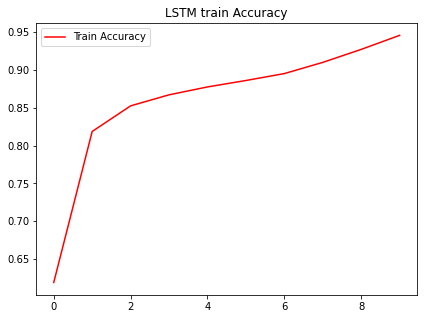

In [75]:
# plotting curve for training accuracy of LSTM
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy', color = 'red')
plt.title("LSTM train Accuracy")
plt.legend()

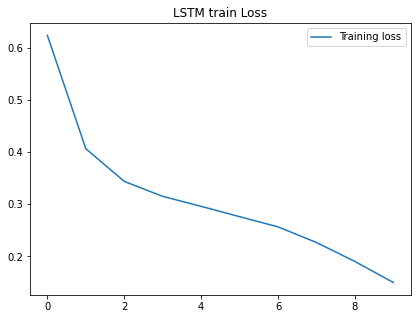

In [76]:
# plotting curve for loss for LSTM training
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.title("LSTM train Loss")
plt.legend()

In [77]:
# testing LSTM model with 10 epochs
clip = 5
num_epochs = 10
test_loss_list = []
test_accuracy = []
for epoch in range(num_epochs):
    test_h = model.init_hidden(batch_size)
    test_losses = []
    test_acc = 0.0
    model.eval()
    for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, test_h = model(inputs, test_h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        output = torch.round(output.squeeze())
        accuracy = torch.sum(output == labels.squeeze()).item()
        test_acc += accuracy
    test_loss_ = np.mean(test_losses)
    test_acc_ = test_acc/len(test_loader.dataset)
    test_loss_list.append(test_loss_)
    test_accuracy.append(test_acc_)
    print(f'Epoch {epoch+1}') 
    print(f'test_loss : {test_loss_} test_accuracy : {test_acc_}')


Epoch 1
test_loss : 0.4467120636818987 test_accuracy : 0.8523636363636363
Epoch 2
test_loss : 0.44758785972089477 test_accuracy : 0.8523636363636363
Epoch 3
test_loss : 0.4464816897204428 test_accuracy : 0.8524242424242424
Epoch 4
test_loss : 0.44730958487048295 test_accuracy : 0.8521818181818182
Epoch 5
test_loss : 0.44704460675517715 test_accuracy : 0.8523636363636363
Epoch 6
test_loss : 0.4475131569712451 test_accuracy : 0.8523030303030303
Epoch 7
test_loss : 0.4473882429414626 test_accuracy : 0.8522424242424242
Epoch 8
test_loss : 0.4477788092060523 test_accuracy : 0.8521212121212122
Epoch 9
test_loss : 0.4467573215112542 test_accuracy : 0.8524242424242424
Epoch 10
test_loss : 0.44693306558059925 test_accuracy : 0.8525454545454545


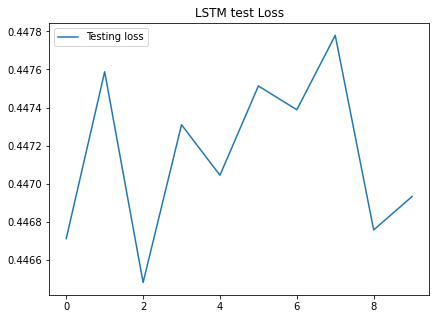

In [78]:
# curve for LSTM test loss
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_list, label='Testing loss')
plt.title("LSTM test Loss")
plt.legend()


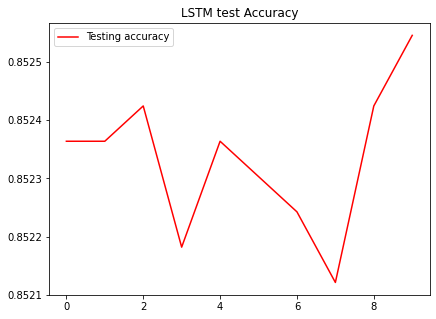

In [79]:
# curve for LSTM test accuracy
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_accuracy, label='Testing accuracy', color = 'red')
plt.title("LSTM test Accuracy")
plt.legend()

In [80]:
# prediction model for custom input
batch_size = 1
def predict(sentence):
    sequence = np.array([vocabulary[preprocessing_data(word)] for word in sentence.split() if preprocessing_data(word) in vocabulary.keys()])
    sequence = np.expand_dims(sequence, axis = 0)
    pad_seq = torch.from_numpy(padding_col(sequence, 300))
    inputs = pad_seq.to(device)
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return (output.item())

In [83]:
# Testing the sentiment of random review from dataset
index = 52
print(f'True sentiment is  : {dataset["sentiment"][index]}')
pred = predict(dataset['review'][index])
if pred > 0.5:
    status = "positive" 
else:
    "negative"
if status == "negative":
    pred = (1 - pred) 
else:
    pred
print(f'Predicted sentiment is {status} with a probability of {pred}')

True sentiment is  : positive
Predicted sentiment is positive with a probability of 0.12613798677921295


In [86]:
# testing with random input sentence
pred = predict("there is good screen play in the movie")
if pred > 0.5:
    status = "positive" 
else:
    "negative"
if status == "negative":
    pred = (1 - pred) 
else:
    pred
print(f'Predicted sentiment is {status} with a probability of {pred}')

Predicted sentiment is positive with a probability of 0.5956729054450989
